# Problem Statement

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

Concepts Used:

Recommender Engine

Collaborative Filtering (Item-based & User-based Approach)

Pearson Correlation

Nearest Neighbors using Cosine Similarity

Matrix Factorization

In [ ]:
!pip install cmfrec

/bin/bash: line 1: 2: No such file or directory


In [ ]:
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 44.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
! pip show pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bigframes, bokeh, bqplot, cmdstanpy, cmfrec, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geemap, geopandas, google-colab, gspread-dataframe, holoviews, ibis-framework, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Data frame formatting

In [ ]:
movies = pd.read_fwf('movies.dat', encoding='ISO-8859-1')
print(movies.shape)
movies.head()

In [ ]:
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'], axis=1, inplace=True)

delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']

movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)
movies1=movies.copy()
movies.head()

In [ ]:
ratings = pd.read_fwf('ratings.dat', encoding='ISO-8859-1')

In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

print(ratings.shape)
ratings1=ratings.copy()
ratings.head()

In [ ]:
users = pd.read_fwf('users.dat', encoding='ISO-8859-1')

In [ ]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users1=users.copy()

In [ ]:
users.head()

In [ ]:
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [ ]:
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [ ]:
print(users.shape)
users.head()

# Exploratory data analysis

In [ ]:
## Extracting year from movie name

movies['Year'] = movies.Title.str.extract('(\(\d\d\d\d\))',expand=False)
movies['Year'] = movies.Year.str.extract('(\d\d\d\d)',expand=False)
movies['Title'] = movies.Title.str.replace('(\(\d\d\d\d\))', '')
movies['Title'] = movies['Title'].apply(lambda x: x.strip())
movies.head()

In [ ]:
dfmov = movies.copy()
dfmov.dropna(inplace=True)
dfmov.Genres = dfmov.Genres.str.split('|')
dfmov['Genres'] = dfmov['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])
for i in dfmov['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'
dfmov.head()

In [ ]:
## Merging above created data frames
df_1 = pd.merge(dfmov, ratings, how='inner', on='MovieID')
df_1.head()

In [ ]:
data = pd.merge(df_1, users, how='inner', on='UserID')
data.head()

In [ ]:
## dataset details

print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])
data.info()

No. of rows:  996144
No. of columns:  11
<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MovieID     996144 non-null  object
 1   Title       996144 non-null  object
 2   Genres      996144 non-null  object
 3   Year        996144 non-null  object
 4   UserID      996144 non-null  object
 5   Rating      996144 non-null  object
 6   Timestamp   996144 non-null  object
 7   Gender      996144 non-null  object
 8   Age         996144 non-null  object
 9   Occupation  996144 non-null  object
 10  Zip-code    996144 non-null  object
dtypes: object(11)
memory usage: 91.2+ MB


There are no missing values in the dataset.

# Feature Engineering

In [ ]:
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s') #Change the datatype from object to date_time
data['Year']=data['Year'].astype('int32') #Change the datatype from object to Integer
data['Rating']=data['Rating'].astype('int32') #Change the datatype from object to Integer
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MovieID     996144 non-null  object        
 1   Title       996144 non-null  object        
 2   Genres      996144 non-null  object        
 3   Year        996144 non-null  int32         
 4   UserID      996144 non-null  object        
 5   Rating      996144 non-null  int32         
 6   Timestamp   996144 non-null  object        
 7   Gender      996144 non-null  object        
 8   Age         996144 non-null  object        
 9   Occupation  996144 non-null  object        
 10  Zip-code    996144 non-null  object        
 11  Datetime    996144 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), object(9)
memory usage: 91.2+ MB


In [ ]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['Year'], bins=bins, labels=labels)
data.head()

Text(0, 0.5, 'Frequency')

<Figure size 800x800 with 0 Axes>

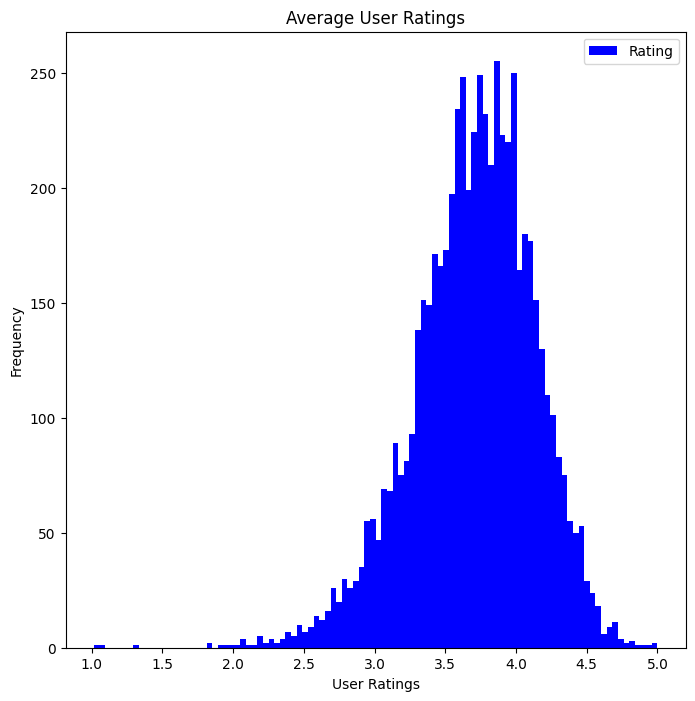

In [ ]:
## Average user ratings
user_ratings =data[['UserID','Rating']].groupby('UserID').mean()

fig = plt.figure(figsize = (8,8))
user_ratings.plot(kind = 'hist', bins = 100, figsize = (8,8), color = 'blue')
plt.plot()
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')

From above plot, we can see that on average, users are rating movies **3.5-4** more frequently than any other rating.
This makes sense since people are less inclined to rate movies lower than a 3 if they didn't enjoy the movie.

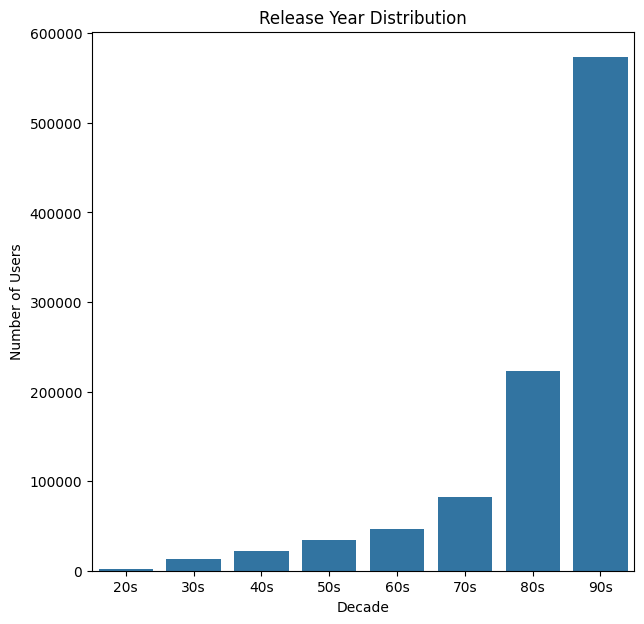

In [ ]:
## Number of movies by release year
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

From the above plot we can infer most of the movies present in the dataset were released in the year **90s**.

In [ ]:
l = dfmov.Genres.iloc[:5]
l

0     [Animation, Children's, Comedy]
1    [Adventure, Children's, Fantasy]
2                   [Comedy, Romance]
3                     [Comedy, Drama]
4                            [Comedy]
Name: Genres, dtype: object

In [ ]:
pd.get_dummies(l.apply(pd.Series).stack()).sum(level=1)
# df.sum(level=1) should use df.groupby(level=1).sum()

<ipython-input-69-ace3a655b646>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.get_dummies(l.apply(pd.Series).stack()).sum(level=1)


,Adventure,Animation,Children's,Comedy,Drama,Fantasy,Romance
0,1,1,0,3,0,0,0
1,0,0,2,0,1,0,1
2,0,0,0,1,0,1,0


In [ ]:
pd.Series(l.iloc[0])

0     Animation
1    Children's
2        Comedy
dtype: object

In [ ]:
dfmov.head(2)

In [ ]:
genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum(level=0)
genres_df.head()

<ipython-input-26-aad133c6aa14>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum(level=0)
<ipython-input-26-aad133c6aa14>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum(level=0)


,,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
### considering only the genre columns for the test
test = genres_df.iloc[:,0:].sum()
test=test.iloc[1:]
print(test)

Action          501
Adventure       282
Animation       104
Children's      249
Comedy         1189
Crime           210
Documentary     124
Drama          1582
Fantasy          62
Film-Noir        44
Horror          340
Musical         113
Mystery         105
Romance         462
Sci-Fi          265
Thriller        488
War             139
Western          68
dtype: int64


In [ ]:
len(test)

18

In [ ]:
print(type(pd.to_numeric(test)))
print(type(test.to_numpy().reshape(18,)[0]))
test2 = test.to_numpy().reshape(18,)

<class 'pandas.core.series.Series'>
<class 'numpy.int64'>


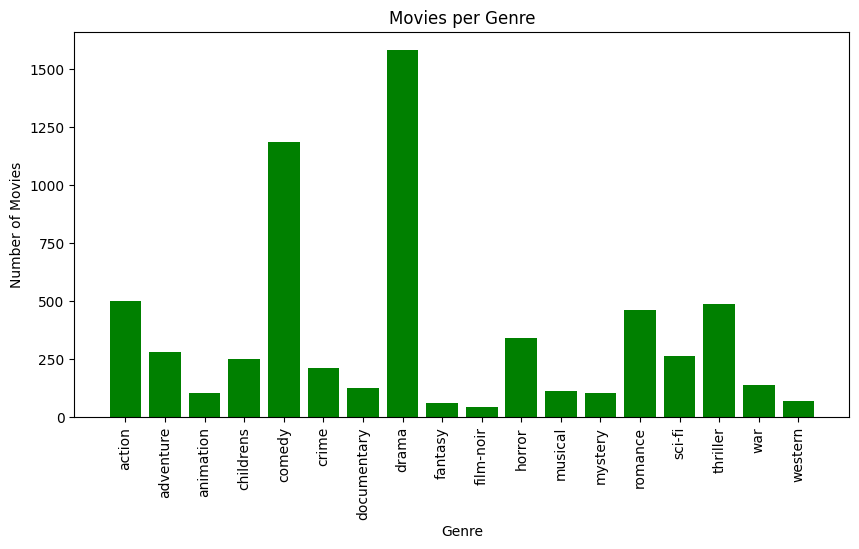

In [ ]:
genre_list=['action', 'adventure','animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama','fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi','thriller', 'war', 'western']
x = np.arange(18)
plt.figure(figsize = (10,5))
plt.bar(x, test2, color = 'g')
plt.xticks(x, genre_list, rotation = 'vertical')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movies per Genre')
sns.set(font_scale=1.5)
plt.show()

From the above plot we can infer that most the movies in the dataset belongs to **Comedy** and **Drama** genres.

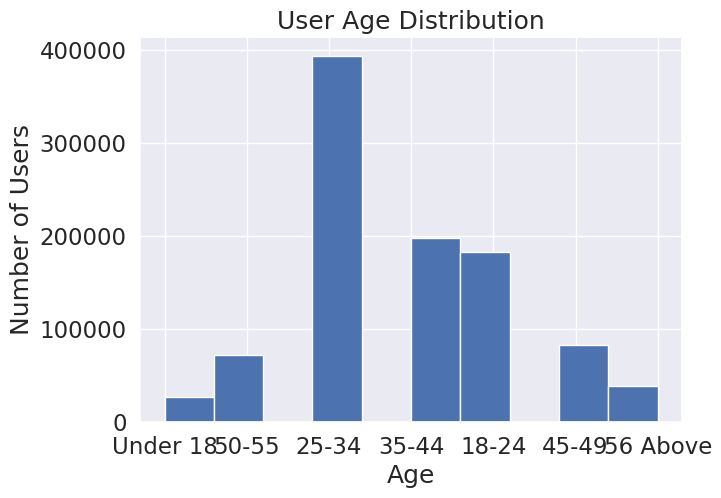

In [ ]:
## Distribution by age
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

From the above plot we can infer that **25-34 age group** have watched and rated the most number of movies

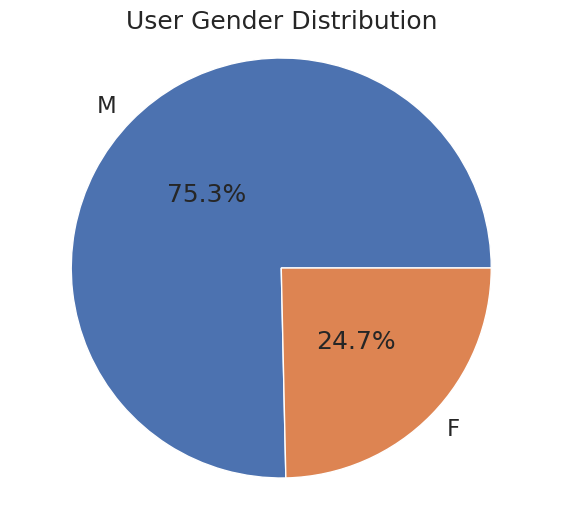

In [ ]:
## Distribution by gender
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()

From the above plot most of the users in our dataset who’ve rated the movies are **Male**.

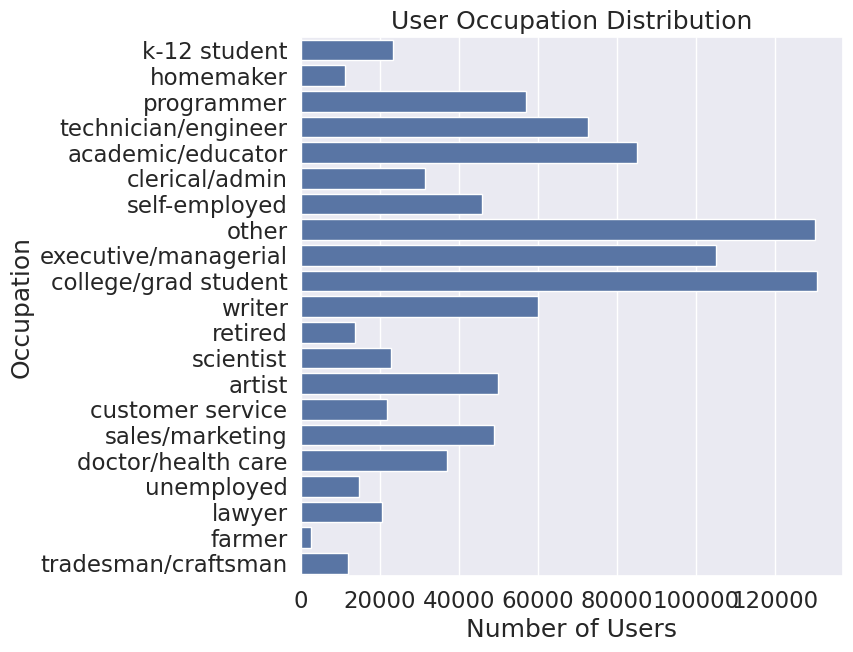

In [ ]:
## Distribution by occupation
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

From the above plot users belonging to **college/grad student** profession have watched and rated the most movies.

<ipython-input-34-e6ecedcaa86a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x="Title", y="totalRatingCount", data=top10_movies, palette="Dark2")
<ipython-input-34-e6ecedcaa86a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")


Text(0, 0.5, 'User Rating count')

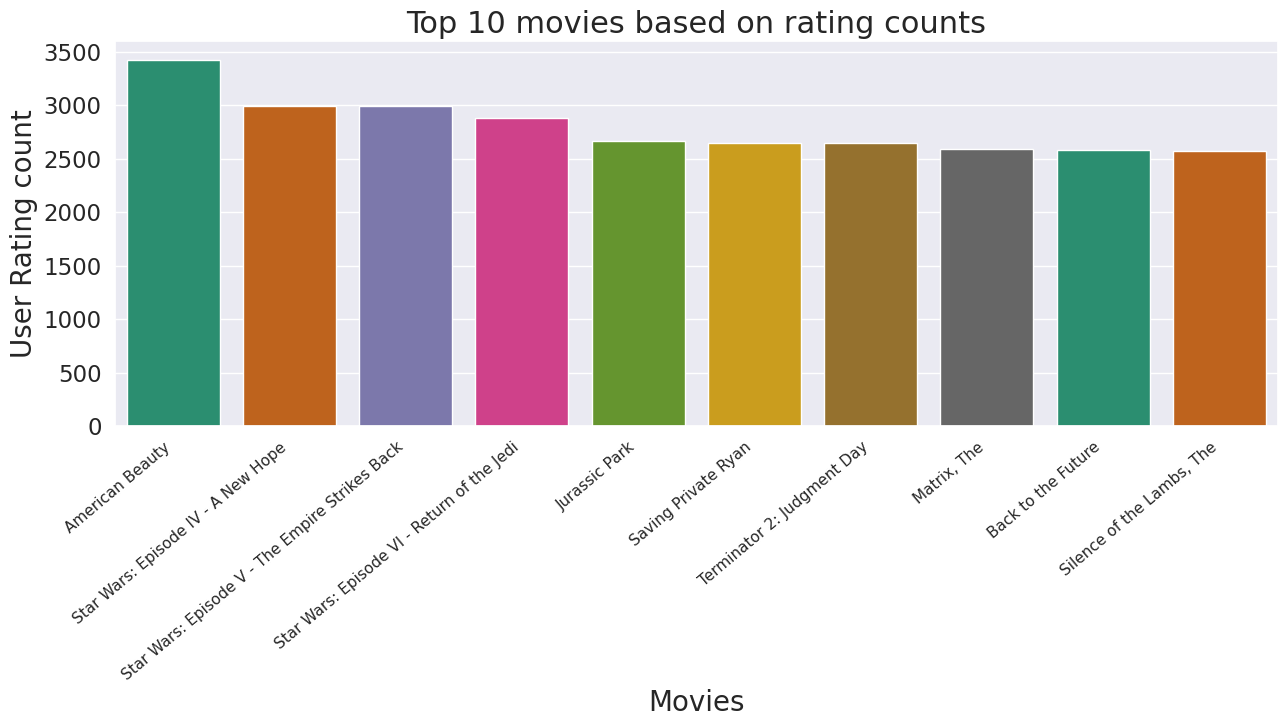

In [ ]:
## Top 10 movies

movies_rating_count = data.groupby(by = ['Title'])['Rating'].count().reset_index()[['Title', 'Rating']] ## Counting the ratings based on movies
movies_rating_count.rename(columns = {'Rating': 'totalRatingCount'},inplace=True)

top10_movies=movies_rating_count[['Title', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)

plt.figure(figsize=(15,5))
ax=sns.barplot(x="Title", y="totalRatingCount", data=top10_movies, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 movies based on rating counts',fontsize = 22)
ax.set_xlabel('Movies',fontsize = 20)
ax.set_ylabel('User Rating count', fontsize = 20)

From the above plot, the movie with maximum number of ratings is **American Beauty**.

# Recommender Systems

## User interaction matrix

Creating a pivot table of movie titles and userid and ratings are taken as values.

In [ ]:
matrix = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
matrix.fillna(0, inplace=True) # Imputing 'NaN' values with Zero rating

print(matrix.shape)

matrix.head(10)

(6040, 3640)


Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Checking data sparsity
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


## Item-based approach

We will take a movie name as an input from the user and see which other 5 (five) movies have maximum correlation with it using Pearson Correlation.

In [ ]:
data[data['Title']=='Home Alone']

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseDec
415,586,Home Alone,"[Children's, Comedy]",1990,10,3,978228747,F,35-44,academic/educator,95370,2000-12-31 02:12:27,90s
822,586,Home Alone,"[Children's, Comedy]",1990,18,4,978155233,F,18-24,clerical/admin,95825,2000-12-30 05:47:13,90s
1742,586,Home Alone,"[Children's, Comedy]",1990,26,2,978140049,M,25-34,executive/managerial,23112,2000-12-30 01:34:09,90s
2705,586,Home Alone,"[Children's, Comedy]",1990,38,4,978046369,F,18-24,college/grad student,02215,2000-12-28 23:32:49,90s
3015,586,Home Alone,"[Children's, Comedy]",1990,45,3,977991192,F,45-49,self-employed,94110,2000-12-28 08:13:12,90s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
975134,586,Home Alone,"[Children's, Comedy]",1990,4273,5,989118624,M,45-49,retired,30030,2001-05-06 03:10:24,90s
977745,586,Home Alone,"[Children's, Comedy]",1990,3385,3,967564715,F,25-34,homemaker,32212,2000-08-29 15:58:35,90s
981262,586,Home Alone,"[Children's, Comedy]",1990,3633,4,966526025,M,35-44,tradesman/craftsman,60441,2000-08-17 15:27:05,90s
990597,586,Home Alone,"[Children's, Comedy]",1990,4846,3,962834091,F,25-34,artist,90066,2000-07-05 21:54:51,90s


In [ ]:
#movie_name = input("Enter a movie name: ")
movie_name='Home Alone'
movie_rating = matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

UserID
1       0.0
10      3.0
100     0.0
1000    0.0
1001    0.0
       ... 
995     0.0
996     0.0
997     0.0
998     0.0
999     0.0
Name: Home Alone, Length: 6040, dtype: float64


In [ ]:
similar_movies = matrix.corrwith(movie_rating) #Finding similar movies
similar_movies

Title
$1,000,000 Duck                        0.148590
'Night Mother                          0.048579
'Til There Was You                     0.082282
'burbs, The                            0.252495
...And Justice for All                 0.040664
                                         ...   
Zed & Two Noughts, A                   0.003394
Zero Effect                            0.146427
Zero Kelvin (Kjærlighetens kjøtere)   -0.006001
Zeus and Roxanne                       0.085158
eXistenZ                               0.051168
Length: 3640, dtype: float64

In [ ]:
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
Title,
Home Alone 2: Lost in New York,0.547203
Mrs. Doubtfire,0.468281
Liar Liar,0.455967
"Mighty Ducks, The",0.446273
Sister Act,0.444612


In [ ]:
#Finding the similarity values between item-item using cosine_similarity
item_sim = cosine_similarity(matrix.T)
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [ ]:
item_sim.shape

(3640, 3640)

## Item-based similarity

In [ ]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head() #Item-similarity Matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


## User-based similarity

In [ ]:
#Finding the similarity values between user-user using cosine_similarity
user_sim = cosine_similarity(matrix)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

In [ ]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399


## Nearest Neighbors

In [ ]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [ ]:
##The distances and indices are being calculated with neighbors being 6
distances, indices = model_knn.kneighbors(matrix.T, n_neighbors= 6)

In [ ]:
result = pd.DataFrame(indices, columns=['Title1', 'Title2', 'Title3', 'Title4', 'Title5','Title6'])
result.head()
#The result dataframe consits of the different indices of movies based on the distance

,Title1,Title2,Title3,Title4,Title5,Title6
0,0,735,416,286,584,3247
1,1,807,72,2167,3036,3369
2,2,1627,2529,3320,2588,1999
3,3,1457,2169,1308,1047,3511
4,4,26,726,894,495,944


In [ ]:
##With this for loop replacing the indices in the result dataframe with movie titles of that corresponding ones
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost,"Barefoot Executive, The",Candleshoe,That Darn Cat!
1,'Night Mother,"Cry in the Dark, A",Agnes of God,Mommie Dearest,Sophie's Choice,"Trip to Bountiful, The"
2,'Til There Was You,If Lucy Fell,Picture Perfect,To Gillian on Her 37th Birthday,Practical Magic,Mad Love
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The",Ghostbusters II,European Vacation,Weekend at Bernie's
4,...And Justice for All,52 Pick-Up,Coma,Deliverance,"Boys from Brazil, The",Dog Day Afternoon


In [ ]:
#movie_name = input("Enter a movie name: ")
movie_name = 'Liar Liar'
result2.loc[result2['Title1']==movie_name] #5 nearest movies for the movie present in Title1.

,Title1,Title2,Title3,Title4,Title5,Title6
1887,Liar Liar,Mrs. Doubtfire,Ace Ventura: Pet Detective,Dumb & Dumber,Home Alone,Wayne's World


## Matrix factorization

In [ ]:
## Creating a pivot table of movie titles and userid and ratings are taken as values.
rm = data.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using Cmfrec Library

In [ ]:
user_itm = data[['UserID', 'MovieID', 'Rating']].copy()
user_itm.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
user_itm.head(2)

,UserId,ItemId,Rating
0,1,1,5
1,1,48,5


In [ ]:
print(user_itm.shape)
print("No.of Users:",len(user_itm['UserId'].unique()))
print("No.of Items:",len(user_itm['ItemId'].unique()))

(996144, 3)
No.of Users: 6040
No.of Items: 3682


In [ ]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(user_itm) #Fitting the model

Collective matrix factorization model
(explicit-feedback variant)


In [ ]:
model.A_.shape, model.B_.shape #model.A_ gives the embeddings of Users and model.B_ gives the embeddings of Items.

((6040, 4), (3682, 4))

In [ ]:
user_itm.Rating.mean(), model.glob_mean_  # Average rating and Global Mean

(3.57998542379415, 3.5799853801727295)

In [ ]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_ #Calculating the predicted ratings

In [ ]:
rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0], squared=False) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse))

Root Mean Squared Error: 1.415


In [ ]:
mape =  mean_absolute_percentage_error(rm.values[rm > 0], rm__[rm > 0]) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.409


### Embeddings for user-user similarity

In [ ]:
user=cosine_similarity(model.A_)

user_sim_matrix = pd.DataFrame(user, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()  #User similarity matrix using the embeddings from matrix factorization

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.088073,0.363078,-0.249395,0.718838,0.332625,-0.010086,-0.625572,-0.449215,-0.569905,...,-0.496325,0.714246,0.437348,-0.171099,0.747024,0.197282,0.826462,-0.311508,0.945377,0.278513
10,-0.088073,1.000000,-0.512670,0.060343,0.581220,0.332946,0.154381,-0.569656,0.040253,0.778155,...,0.520587,0.616675,0.529284,0.321486,-0.210402,-0.671947,-0.586832,-0.008255,-0.406879,0.662922
100,0.363078,-0.512670,1.000000,0.659688,-0.069559,0.485552,0.656270,0.443274,0.451820,-0.261294,...,-0.066160,-0.179580,0.426872,0.103937,0.857165,0.880987,0.506355,0.234021,0.502850,0.279745
1000,-0.249395,0.060343,0.659688,1.000000,-0.195940,0.542990,0.924487,0.580668,0.891166,0.533799,...,0.604393,-0.278901,0.580906,0.369959,0.435821,0.550717,-0.294509,0.409845,-0.246904,0.562157
1001,0.718838,0.581220,-0.069559,-0.195940,1.000000,0.596940,-0.019081,-0.878569,-0.454072,0.046251,...,-0.203922,0.939292,0.632261,0.281837,0.416944,-0.394899,0.316749,-0.040267,0.475994,0.678728


In [ ]:
itm=cosine_similarity(model.B_)

itm_sim_matrix = pd.DataFrame(itm, index=user_itm['ItemId'].unique(), columns=user_itm['ItemId'].unique())
itm_sim_matrix.head()#Item similarity matrix using the embeddings from matrix factorization

,1,48,150,260,527,531,588,594,595,608,...,872,2480,3656,3172,989,3280,642,1915,3779,1832
1,1.000000,-0.058749,0.954507,0.911087,0.952640,0.666721,0.909237,0.764234,0.882831,0.659934,...,-0.184447,-0.095996,0.147259,0.494630,0.158347,-0.558085,0.217393,0.762121,-0.653695,0.603450
48,-0.058749,1.000000,0.085030,-0.385942,-0.355209,0.483500,0.360928,0.375136,0.379983,-0.481997,...,0.963261,0.543983,-0.148307,-0.425367,-0.872222,-0.610512,0.756991,-0.033797,0.273007,-0.375904
150,0.954507,0.085030,1.000000,0.880058,0.879090,0.571414,0.934890,0.666851,0.876782,0.441278,...,-0.005420,-0.229939,-0.111797,0.409813,-0.087008,-0.576731,0.199331,0.880960,-0.671111,0.683148
260,0.911087,-0.385942,0.880058,1.000000,0.975596,0.313627,0.697035,0.438496,0.621809,0.683195,...,-0.476215,-0.464876,0.030740,0.659084,0.354433,-0.202909,-0.198420,0.786868,-0.672279,0.749555
527,0.952640,-0.355209,0.879090,0.975596,1.000000,0.454423,0.743251,0.583664,0.709877,0.731476,...,-0.451188,-0.287021,0.132093,0.572249,0.385567,-0.340903,-0.036010,0.755862,-0.721564,0.713486


In [ ]:
movie_name='586'
movie_rating = itm_sim_matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

1       0.249708
48      0.851780
150     0.469817
260     0.041049
527    -0.005561
          ...   
3280   -0.569207
642     0.493824
1915    0.407039
3779   -0.012897
1832    0.053562
Name: 586, Length: 3682, dtype: float32


In [ ]:
similar_movies = itm_sim_matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
2875,0.999276
3482,0.997829
3565,0.997180
3594,0.997163
653,0.996334


In [ ]:
item_mov = data[['MovieID', 'Title']].copy()
item_mov.drop_duplicates(inplace=True)
item_mov.reset_index(drop=True,inplace=True)

sim_df1= sim_df.copy()
sim_df1.reset_index(inplace=True)
sim_df1.rename(columns = {'index':'MovieID'}, inplace = True)
sim_mov = pd.merge(sim_df1,item_mov,on='MovieID',how='inner')
sim_mov.head(6)

,MovieID,Correlation,Title
0,586,1.000000,Home Alone
1,2875,0.999276,Sommersby
2,3482,0.997829,Price of Glory
3,3565,0.997180,Where the Heart Is
4,3594,0.997163,Center Stage
5,653,0.996334,Dragonheart


In [ ]:
model1 = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model1.fit(user_itm)

Collective matrix factorization model
(explicit-feedback variant)


<ipython-input-66-2a256facb23f>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(model1.A_[:, 0], model1.A_[:, 1], cmap = 'hot')


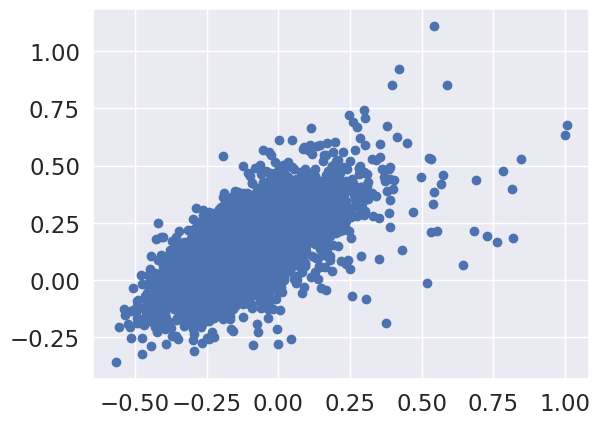

In [ ]:
plt.scatter(model1.A_[:, 0], model1.A_[:, 1], cmap = 'hot')

<ipython-input-67-c15f14632eee>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(model1.B_[:, 0], model1.B_[:, 1], cmap='hot')


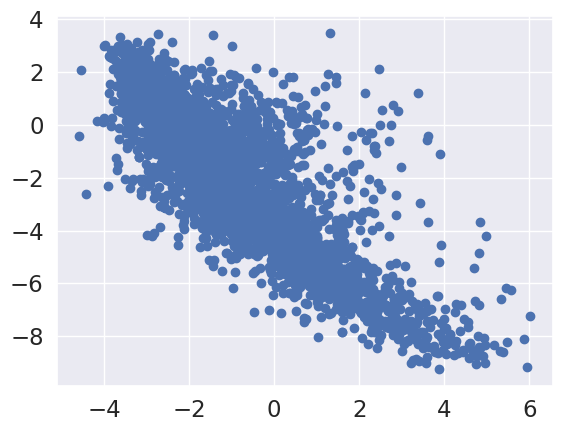

In [ ]:
plt.scatter(model1.B_[:, 0], model1.B_[:, 1], cmap='hot')

1. Users of **25-34 age group** have watched and rated the most number of movies

2. Users who are **college/grad student** have watched and rated the most movies

3. Most of the users in our dataset who’ve rated the movies are Male

4. Most of the movies present on our dataset were released in **90s** decade

5. The movie with maximum no. of ratings is **American Beauty**

6. Top 3 movies similar to ‘Liar Liar’ on the item-based approach - **Mrs. Doubtfire, Ace Ventura: Pet, Detective Dumb & Dumber**
